# Potential Talents
As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

## Import Libraries

In [50]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from scipy.spatial.distance import cosine

# gensim
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

from sentence_transformers import SentenceTransformer

# random
import random
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

"\nfrom numpy import dot\nfrom numpy.linalg import norm\n# sklearn\nfrom sklearn.model_selection import train_test_split\n\n# scipy\nfrom scipy.spatial.distance import cosine\n\n\n# random\nimport random\n# pytorch\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.optim as optim\n# matplotlib\nimport matplotlib.pyplot as plt\n# Ignore warnings\nwarnings.filterwarnings('ignore')\n"

In [2]:
data = pd.read_csv('potentialTalents', index_col='id')

In [3]:
data.head()

,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    object 
 3   fit         0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 4.1+ KB


## Data Cleaning / Preprocessing
Make sure the data only contains values that contain useful information

Originally, number of rows in dataframe = 104
After dropping duplicates number of rows in dataframe = 53


Text(0.5, 0, 'Number of Candidates')

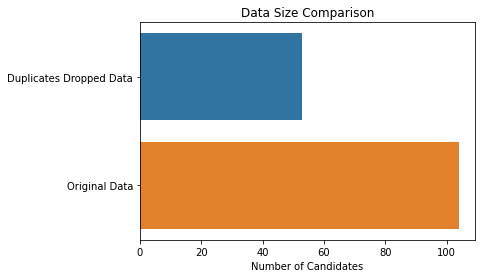

In [5]:
# Drop Duplicates
print('Originally, number of rows in dataframe =', len(data))
dataDupDrop = data.drop_duplicates()
print('After dropping duplicates number of rows in dataframe =', len(dataDupDrop))

plt.figure()
sn.barplot(y=['Duplicates Dropped Data','Original Data'],x=[len(dataDupDrop), len(data)])
plt.title("Data Size Comparison")
plt.xlabel('Number of Candidates')

################### Check colour scheme after ##################

In [6]:
dataDupDrop.describe(include='all')

,job_title,location,connection,fit
count,53,53,53,0.0
unique,52,41,33,NaN
top,Aspiring Human Resources Professional,"Houston, Texas Area",500+,NaN
freq,2,4,18,NaN
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN


In [7]:
# Clean the data: Remove stop words, change shortform words,
# remove punctuation, lemmatize words, change to lower case

cleanData = dataDupDrop.copy()
cleanData['cleanJobTitle'] = ""

stopWords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for i in dataDupDrop.index :
    # Fetch appropriate jobTitle
    jobTitle = dataDupDrop['job_title'][i]
    tempString = ''
    # Replace HR with human resources
    tempString = jobTitle.replace("HR", " human resources ")
    # Make word all lower case
    tempString = tempString.lower()
    
    # Initialize empty wordList array for jobTitle
    wordList = []
    
    for token in tempString.split() :
        # Initialize variable
        word = ""
        # Remove all characters except letters and numbers
        temp = list([e for e in token if e.isalnum()])
        # Join letters from temp list back together
        word = "".join(temp)
        
        # Lemmatize word
        word = lemmatizer.lemmatize(word)
        
        if word not in stopWords :
            wordList.append(word)
    
    # Join tokens from wordList array with spaces inbetween
    cleanJobTitle = " ".join(wordList)
    
    cleanData['cleanJobTitle'][i] = cleanJobTitle

In [8]:
cleanData.head()

,job_title,location,connection,fit,cleanJobTitle
id,,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 ct bauer college business graduate magna ...
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik english program korea
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resource professional
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university


## Generate Scores
Similarity scores will be generated based on their similarity to the key phrases:
- Aspiring human resources
- Seeking human resources

This will be done by vectorizing both the job title and key phrases using various vectorizers and then calculating the cosine similarity between them

In [9]:
# Initialize search phrases and job title list
searchPhrase = ['aspiring human resources', 'seeking human resources']
# Lemamtize search phrase
for i in range(len(searchPhrase)) :
    phrase = searchPhrase[i]
    lemmaPhrase = ""
    for token in phrase.split() :
        word = lemmatizer.lemmatize(token)
        lemmaPhrase += " " + word
        
    searchPhrase[i] = phrase
    
jobTitleList = list(cleanData['cleanJobTitle'])

### TFIDF Cosine Similarity Score


In [10]:
def cosineSimilarity(vector1, vector2) :
    return 1 - cosine(vector1, vector2)

In [11]:
# TFIDF of job titles
vectorizer = TfidfVectorizer()
tfidfVectors = vectorizer.fit_transform(list(cleanData['cleanJobTitle'])).toarray()

print('Shape of Job title Tfidf vector: ', tfidfVectors.shape)

# TFIDF of search phrases
searchVectors = vectorizer.transform(searchPhrase).toarray()
print('Shape of search phrases tfidf vector: ', searchVectors.shape)

Shape of Job title Tfidf vector:  (53, 176)
Shape of search phrases tfidf vector:  (2, 176)


In [12]:
# Calculate average of TFIDF Cosine Similarity Scores of job titles to 
# each search phrase
cosSimScore = []
score1Array = []
score2Array = []

for i in range(len(cleanData)) :
    score1 = cosineSimilarity(tfidfVectors[i], searchVectors[0])
    score2 = cosineSimilarity(tfidfVectors[i], searchVectors[1])
    score1Array.append(score1)
    score2Array.append(score2)
    cosSimScore.append((score1+score2)/2)
    
cleanData['score1'] = score1Array
cleanData['score2'] = score2Array
cleanData['cosSimScore'] = cosSimScore

In [13]:
cleanData[['job_title', 'cleanJobTitle', 'cosSimScore']].sort_values(by=['cosSimScore'], ascending=False).head()

,job_title,cleanJobTitle,cosSimScore
id,,,
73,"Aspiring Human Resources Manager, seeking inte...",aspiring human resource manager seeking intern...,0.492442
3,Aspiring Human Resources Professional,aspiring human resource professional,0.423572
97,Aspiring Human Resources Professional,aspiring human resource professional,0.423572
27,Aspiring Human Resources Management student se...,aspiring human resource management student see...,0.398858
99,Seeking Human Resources Position,seeking human resource position,0.390371


### Word Embedding
"embeds" a word in a cluster of words based on how similar it is to all of the words in the cluster.
#### GloVe Global Vectors

In [14]:
# Create Temporary File
targetFile = get_tmpfile('word2vec.42B.300d.txt')
# Assign embeddings to it
glove2word2vec('glove.42B.300d.txt', targetFile)

# Load the converted embeddings into memory
gloveModel = KeyedVectors.load_word2vec_format(targetFile)

# Save as Binary Data
gloveModel.save_word2vec_format('word2vec.42B.300d.bin.gz', binary=True)

In [15]:
def tokenVectors(sentence, model, vectorDim) :
    # Tokenize sentence
    tokens = word_tokenize(sentence)
    
    # Find filtered words
    filteredWords = [w for w in tokens if w in model.index2word]
    
    for word in tokens :
        # Check if word is in filtered words
        if word in filteredWords :
            # Add to model
            tokenVector = model[word]
            
    return tokenVector
    

In [16]:
# Vectorize clean job title using the GloVe model
gloveVectors = []
for job in cleanData['cleanJobTitle'] :
    gloveVectors.append(tokenVectors(job, gloveModel, 50))

# Vectorize search phrase vectors
searchVectors = []
for phrase in searchPhrase :
    searchVectors.append(tokenVectors(phrase, gloveModel, 50))

In [17]:
# Cosine similarity
gloveScore = []
for i in range(len(gloveVectors)) :
    score1 = cosineSimilarity(gloveVectors[i], searchVectors[0])
    score2 = cosineSimilarity(gloveVectors[i], searchVectors[1])
    gloveScore.append((score1+score2)/2)
    
cleanData['GloVe Score'] = gloveScore

cleanData[['job_title', 'cleanJobTitle', 'GloVe Score']].sort_values(by=['GloVe Score'], ascending=False).head()

,job_title,cleanJobTitle,GloVe Score
id,,,
73,"Aspiring Human Resources Manager, seeking inte...",aspiring human resource manager seeking intern...,0.852136
12,"SVP, CHRO, Marketing & Communications, CSR Off...",svp c human resource marketing communication ...,0.852136
70,"Retired Army National Guard Recruiter, office ...",retired army national guard recruiter office m...,0.852136
76,Aspiring Human Resources Professional | Passio...,aspiring human resource professional passiona...,0.567514
81,Senior Human Resources Business Partner at Hei...,senior human resource business partner heil en...,0.562195


#### Word2Vec

It is a popular word embedding technique using a 2-layer neural network.It works in a way such that a well-trained set of word vectors will place similar words close to each other in that space.

There are two main training algorithims within Word2Vec: Continuous Bag of Words(CBOW) and Skip-Gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two semantics for a single word.

In [18]:
w2vModel = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

In [19]:
# Vectorize Job Title
w2vVectors = []
for job in cleanData['cleanJobTitle'] :
    w2vVectors.append(tokenVectors(job, w2vModel, 50))

print(np.shape(w2vVectors[0]))        

# Vectorize search phrases
w2vSearchVectors = []
for phrase in searchPhrase :
    w2vSearchVectors.append(tokenVectors(phrase, w2vModel, 50))
    
print(np.shape(w2vSearchVectors[0]))

(300,)
(300,)


In [20]:
# Cosine similarity
w2vScore = []
for i in range(len(gloveVectors)) :
    score1 = cosineSimilarity(w2vVectors[i], w2vSearchVectors[0])
    score2 = cosineSimilarity(w2vVectors[i], w2vSearchVectors[1])
    w2vScore.append((score1+score2)/2)
    
cleanData['w2v Score'] = w2vScore

cleanData[['job_title', 'cleanJobTitle', 'w2v Score']].sort_values(by=['w2v Score'], ascending=False).head()

,job_title,cleanJobTitle,w2v Score
id,,,
70,"Retired Army National Guard Recruiter, office ...",retired army national guard recruiter office m...,0.691418
12,"SVP, CHRO, Marketing & Communications, CSR Off...",svp c human resource marketing communication ...,0.691418
73,"Aspiring Human Resources Manager, seeking inte...",aspiring human resource manager seeking intern...,0.691418
78,Human Resources Generalist at Schwan's,human resource generalist schwans,0.283192
101,Human Resources Generalist at Loparex,human resource generalist loparex,0.283192


### BERT Bidirectional Encoder Representations and Transformers

In [21]:
# Build BERT_base model
bertModel = SentenceTransformer('bert-base-nli-mean-tokens')

In [22]:
# Calculate vectors of job title from bert model
bertVectors = bertModel.encode(list(cleanData['cleanJobTitle']))
# Calculate vectors of search phrases from bert model
bertSearchVectors = bertModel.encode(list(searchPhrase))

print(bertVectors.shape)
print(bertSearchVectors.shape)

(53, 768)
(2, 768)


In [23]:
# Calculate cosine similarities between bert job title vectors and 
# bert search phrase vectors
bertScore = []
for i in range(len(gloveVectors)) :
    score1 = cosineSimilarity(bertVectors[i], bertSearchVectors[0])
    score2 = cosineSimilarity(bertVectors[i], bertSearchVectors[1])
    bertScore.append((score1+score2)/2)
    
cleanData['BERT Score'] = bertScore

cleanData[['job_title', 'cleanJobTitle', 'BERT Score']].sort_values(by=['BERT Score'], ascending=False).head()

,job_title,cleanJobTitle,BERT Score
id,,,
99,Seeking Human Resources Position,seeking human resource position,0.901509
28,Seeking Human Resources Opportunities,seeking human resource opportunity,0.892522
6,Aspiring Human Resources Specialist,aspiring human resource specialist,0.843139
10,Seeking Human Resources HRIS and Generalist Po...,seeking human resource human resource generali...,0.831111
3,Aspiring Human Resources Professional,aspiring human resource professional,0.827415


## Average similarity scores from all methods previously used

In [24]:
scoreColumnNames = cleanData.columns[[7,8,9,10]]

cleanData['Average Score'] = cleanData[scoreColumnNames].mean(axis=1)

In [25]:
cleanData[['job_title', 'cleanJobTitle', 'Average Score']].sort_values(by=['Average Score'],ascending=False).head()

,job_title,cleanJobTitle,Average Score
id,,,
73,"Aspiring Human Resources Manager, seeking inte...",aspiring human resource manager seeking intern...,0.671109
12,"SVP, CHRO, Marketing & Communications, CSR Off...",svp c human resource marketing communication ...,0.533221
70,"Retired Army National Guard Recruiter, office ...",retired army national guard recruiter office m...,0.529034
28,Seeking Human Resources Opportunities,seeking human resource opportunity,0.517247
6,Aspiring Human Resources Specialist,aspiring human resource specialist,0.470783


# Rerank when a candidate is starred
First method, asks for whcih candidates are to be starred and then adds that candidate's job title to the search phrase.  The result for each vectorizing method is the average of all the search phrases.  The final result is then the average of all the averaged vectorizer cosine similarities with equal weighting.

In [26]:
finalData = cleanData[['cleanJobTitle', 'fit']]

In [27]:
# Initialize search phrases and job title list
searchPhrase = ['aspiring human resources', 'seeking human resources']

starCandidate = input("Do you want to star any candidates? Enter 'yes' or 'no': ")

starred = []
if starCandidate == 'yes':
    starred = [int(item) for item in input("Enter ids of candidates you want to star (separated by space) : ").split()]

Do you want to star any candidates? Enter 'yes' or 'no':  yes
Enter ids of candidates you want to star (separated by space) :  76


In [28]:
for i in starred :
    searchPhrase.append(cleanData['cleanJobTitle'][i])

In [29]:
# Vectorize Search Vectors
tfidfSearchVectors = vectorizer.transform(searchPhrase).toarray()

gloveSearchVectors = []
w2vSearchVectors = []
for phrase in searchPhrase :
    gloveSearchVectors.append(tokenVectors(phrase, gloveModel, 50))
    w2vSearchVectors.append(tokenVectors(phrase, w2vModel, 50))
    
bertSearchVectors = bertModel.encode(list(searchPhrase))

In [30]:
# Calculate Cosine Similarity Between jobTitleVectors and new search Phrase vectors

# Initialize Arrays
tfidfScore = np.zeros(len(tfidfVectors))
gloveScore = np.zeros(len(tfidfVectors))
w2vScore = np.zeros(len(tfidfVectors))
bertScore = np.zeros(len(tfidfVectors))

# Loop through and add up scores for all search phrases
for i in range(len(tfidfVectors)) :
    for j in range(len(tfidfSearchVectors)) :
        tfidfScore[i] += cosineSimilarity(tfidfVectors[i], tfidfSearchVectors[j])
        gloveScore[i] += cosineSimilarity(gloveVectors[i], gloveSearchVectors[j])
        w2vScore[i] += cosineSimilarity(w2vVectors[i], w2vSearchVectors[j])
        bertScore[i] += cosineSimilarity(bertVectors[i], bertSearchVectors[j])
        

# Assign score for each vector group as average of scores for each search vector
finalData['tfidf'] = tfidfScore/len(tfidfSearchVectors)
finalData['glove'] = gloveScore/len(tfidfSearchVectors)
finalData['word2vec'] = w2vScore/len(tfidfSearchVectors)
finalData['bert'] = bertScore/len(tfidfSearchVectors)

# Assign final fit as average of all average vector scores
finalData['fit'] = finalData[['tfidf', 'glove', 'word2vec', 'bert']].mean(axis=1)

In [31]:
finalData.sort_values(by=['fit'], ascending=False)

,cleanJobTitle,fit,tfidf,glove,word2vec,bert
id,,,,,,
76,aspiring human resource professional passiona...,0.604425,0.427562,0.711676,0.511317,0.767144
73,aspiring human resource manager seeking intern...,0.584727,0.379939,0.751754,0.543520,0.663692
28,seeking human resource opportunity,0.465434,0.273989,0.536371,0.236742,0.814636
12,svp c human resource marketing communication ...,0.461642,0.111310,0.751754,0.543520,0.439985
70,retired army national guard recruiter office m...,0.454587,0.112087,0.751754,0.543520,0.410987
97,aspiring human resource professional,0.442430,0.393612,0.472042,0.082539,0.821528
3,aspiring human resource professional,0.442430,0.393612,0.472042,0.082539,0.821528
99,seeking human resource position,0.426140,0.283489,0.415805,0.200264,0.805001
6,aspiring human resource specialist,0.425506,0.305837,0.474820,0.109616,0.811750


## ReRanking using RankNet
The idea here is to Re-ranking our job titles when a candidate is starred

Working of RankNet
1. A neural network with Linear, Dropout and activation layers is built which takes job title as input and returns a prediction.
2. Two random samples from the job titles are selected and their output is computed separately using forward propagation.
3. The cost, which is the difference between the two outputs is calculated and appropriate loss is calculated.
4. The loss is back-propogated to learn the selected example.
5. Steps 2-4 are repeated until the training is complete based on epochs.

In [35]:
# Copy the data base
rankNetData = cleanData.copy()

In [36]:
# Ask to star candidates
starCandidate = input("Do you want to star any candidates? Enter 'yes' or 'no': ")

starred = []
if starCandidate == 'yes':
    starred = [int(item) for item in input("Enter ids of candidates you want to star (separated by space) : ").split()]
    # 10, 82, 99

Do you want to star any candidates? Enter 'yes' or 'no':  yes
Enter ids of candidates you want to star (separated by space) :  10 82 99


In [48]:
# Create a new column in the dataset that has the 'starred score'
rankNetData['starredScore'] = rankNetData['Average Score']

for i in starred :
    rankNetData.at[i, 'starredScore'] = 1

In [51]:
# Set seed for reproducability
random.seed(42)

# Build a Deep Learning RankNet class
class RankNet(nn.Module):
    
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),         # Linear layer - linear projection
            nn.Dropout(0.5),                     # Regularization - Drops some of the neurons in a random fashion
            nn.LeakyReLU(0.2, inplace=True),     # Activation function
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()                         # Applies a function on the output and brings the output bw 0 and 1
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

In [53]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

# Generat input for RankNet model
random_row_1 = rankNetData.sample(n = 5000, replace = True)
random_row_2 = rankNetData.sample(n = 5000, replace = True)
job_title_list_ranknet1 = list(random_row_1['cleanJobTitle'])
job_title_list_ranknet2 = list(random_row_2['cleanJobTitle'])
doc1 = bert_model.encode(job_title_list_ranknet1)
doc2 = bert_model.encode(job_title_list_ranknet2)
doc1 = torch.from_numpy(doc1).float()
doc2 = torch.from_numpy(doc2).float()

In [57]:
# Generate ground truth for RankNet model
y1 = list(random_row_1['starredScore'])
y2 = list(random_row_2['starredScore'])
y = torch.tensor([1.0 if y1_i>y2_i 
                  else 0.5 if y1_i==y2_i 
                  else 0.0 
                  for y1_i, y2_i in zip(y1, y2)]).float()
y = y.unsqueeze(1)

In [58]:
# Initialize an instance of RankNet model and define loss function
rank_model = RankNet(num_feature = 768)
# optimizer = torch.optim.Adam(rank_model.parameters())         
optimizer = torch.optim.SGD(rank_model.parameters(), lr = 0.01, momentum = 0.9)        
loss_fun = torch.nn.BCELoss()             # BCE is generally used for NLP problems

In [59]:
# Run RankNet model through various iterations until loss is optimized
epoch = 3000
losses = []

for i in range(epoch):
    rank_model.zero_grad()
    y_pred = rank_model(doc1, doc2)
    loss = loss_fun(y_pred,y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    #print(y1, y2, y, y_pred)
    
    if i % 100 == 0:
        print('Epoch{}, loss : {}'.format(i, loss.item()))

Epoch0, loss : 0.6942194700241089
Epoch100, loss : 0.5651938319206238
Epoch200, loss : 0.5238719582557678
Epoch300, loss : 0.5101827383041382
Epoch400, loss : 0.5061348080635071
Epoch500, loss : 0.5039986371994019
Epoch600, loss : 0.5042768716812134
Epoch700, loss : 0.5039899945259094
Epoch800, loss : 0.5033541917800903
Epoch900, loss : 0.5022065043449402
Epoch1000, loss : 0.5030540823936462
Epoch1100, loss : 0.501823365688324
Epoch1200, loss : 0.5019688606262207
Epoch1300, loss : 0.5025746822357178
Epoch1400, loss : 0.5020642280578613
Epoch1500, loss : 0.5023343563079834
Epoch1600, loss : 0.5021296739578247
Epoch1700, loss : 0.5023764371871948
Epoch1800, loss : 0.50185626745224
Epoch1900, loss : 0.5024182200431824
Epoch2000, loss : 0.5014550089836121
Epoch2100, loss : 0.5021493434906006
Epoch2200, loss : 0.5016030073165894
Epoch2300, loss : 0.5026252269744873
Epoch2400, loss : 0.5011335611343384
Epoch2500, loss : 0.5018765330314636
Epoch2600, loss : 0.5026247501373291
Epoch2700, loss 

Text(0.5, 1.0, 'Loss vs Epochs')

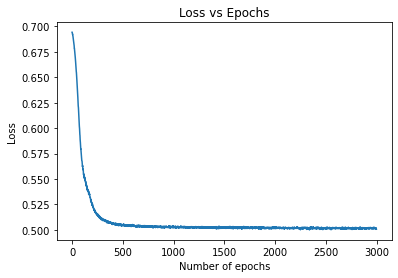

In [60]:
# Plot a graph for loss vs number of iterations 
x = list(range(3000))
plt.plot(x, losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")

In [63]:
# Make predictions for the initial dataset and create a new column for final cosine similarity
predScore = []
for job in rankNetData['cleanJobTitle'] :
    embedding = bert_model.encode([job])
    embedding_tensor = torch.from_numpy(embedding).float()
    pred = round(rank_model.predict(embedding_tensor).detach().numpy().sum(),2)
    predScore.append(pred)

rankNetData['RankNN_score'] = predScore
rankNetData.sort_values(by ='RankNN_score', ascending = False)

,job_title,location,connection,fit,cleanJobTitle,score1,score2,cosSimScore,GloVe Score,w2v Score,BERT Score,Average Score,starredScore,RankNN_score
id,,,,,,,,,,,,,,
67,"Human Resources, Staffing and Recruiting Profe...","Jackson, Mississippi Area",500+,NaN,human resource staffing recruiting professional,0.108445,0.100735,0.104590,0.475239,0.094600,0.698631,0.343265,0.343265,1.00
12,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,NaN,svp c human resource marketing communication ...,0.140124,0.130162,0.135143,0.852136,0.691418,0.454186,0.533221,0.533221,1.00
84,Human Resources professional for the world lea...,"Highland, California",50,NaN,human resource professional world leader gi so...,0.080077,0.074384,0.077230,0.504458,0.195808,0.619571,0.349267,0.349267,1.00
73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,NaN,aspiring human resource manager seeking intern...,0.481429,0.503455,0.492442,0.852136,0.691418,0.648440,0.671109,0.671109,1.00
82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,NaN,aspiring human resource professional energeti...,0.331490,0.081127,0.206308,0.418145,0.094563,0.740516,0.364883,1.000000,1.00
66,Experienced Retail Manager and aspiring Human ...,"Austin, Texas Area",57,NaN,experienced retail manager aspiring human reso...,0.358792,0.087809,0.223300,0.475239,0.094600,0.544852,0.334498,0.334498,1.00
28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seeking human resource opportunity,0.148362,0.606217,0.377290,0.549586,0.249590,0.892522,0.517247,0.517247,1.00
27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,NaN,aspiring human resource management student see...,0.384157,0.413559,0.398858,0.362093,0.108115,0.598481,0.366887,0.366887,1.00
74,Human Resources Professional,Greater Boston Area,16,NaN,human resource professional,0.220909,0.205204,0.213056,0.475239,0.094600,0.807203,0.397525,0.397525,1.00


## Conclusion
After using Various NLP techniques such as TF-IDF, word2vec, gloVe and BERT to check the Similarity for two sentences 'Aspiring human resources' and 'seeking human resources' by applying the cosine-similarity and then the mean of the 4 cosine similarity scores for each aforementioned NLP technique. Then, apply Re-rank of the job title based on the candidate is starred using RankNet deep learning model.

The above table shows the rank based on the candidate that entered by the user.  Candidates starred for this process were 10, 82, 99